biof 509 project - 
spring 2020 - 
by Neil Perkins

### Goal: predictors of covid 19

### Data: Official Covid data from Mexican Health Department
    
Independent suspicious and confirmed cases files stopped being distributed by the government on April 18th 2020. Posted on kaggle.com by Eduardo Rojas.

https://www.kaggle.com/lalish99/covid19-mx

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Data

Read in the data

In [68]:
df1mx = pd.read_csv('covid-19_general_MX.csv')
df2cases = pd.read_csv('casos_confirmados.csv')

Data dimensions

In [69]:
df1mx.shape

(95839, 26)

In [70]:
df2cases.shape

(23471, 6)

Data descriptives

In [71]:
type(df1mx)

pandas.core.frame.DataFrame

In [72]:
df1mx.head()

,Unnamed: 0,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_RES,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,FECHA_DEF,INTUBADO,...,INMUSUPR,HIPERTENSION,OTRA_CON,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,RESULTADO,UCI
0,0,4,17,2,17,1,2020-03-09,2020-03-09,9999-99-99,97,...,2,2,2,2,2,2,2,99,1,97
1,1,4,9,1,9,1,2020-03-19,2020-03-17,9999-99-99,97,...,2,2,2,2,2,2,2,99,1,97
2,2,4,2,2,2,2,2020-03-19,2020-03-19,9999-99-99,2,...,2,1,2,2,1,2,2,99,1,2
3,3,4,9,2,9,2,2020-03-30,2020-03-24,2020-04-01,2,...,2,2,2,2,2,2,2,99,1,2
4,4,12,14,1,14,2,2020-03-29,2020-03-26,9999-99-99,2,...,2,2,2,2,2,2,2,2,2,2


Rename columns to english

    - could use .rename
    - too many so used .columns to redo entire list

In [73]:
df1mx.columns=['ID','SECTOR','state_care','sex',
               'state_live','ambulatory','care_date',
               'sympt_date','dead_date','intubate',
               'neumonia','age','nation','diabetes',
               'epoch','asthma','immunosprs','hyperten',
               'OtherDis','CardioDis','Obesity','RenalDis',
               'tabaquism','COVID_contact','COVID','ICU']

Look for missing data

In [74]:
df1na=df1mx.isna()

In [75]:
df1na.describe()

,ID,SECTOR,state_care,sex,state_live,ambulatory,care_date,sympt_date,dead_date,intubate,...,immunosprs,hyperten,OtherDis,CardioDis,Obesity,RenalDis,tabaquism,COVID_contact,COVID,ICU
count,95839,95839,95839,95839,95839,95839,95839,95839,95839,95839,...,95839,95839,95839,95839,95839,95839,95839,95839,95839,95839
unique,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,95839,95839,95839,95839,95839,95839,95839,95839,95839,95839,...,95839,95839,95839,95839,95839,95839,95839,95839,95839,95839


In [76]:
df1mx.isna().sum()

ID               0
SECTOR           0
state_care       0
sex              0
state_live       0
ambulatory       0
care_date        0
sympt_date       0
dead_date        0
intubate         0
neumonia         0
age              0
nation           0
diabetes         0
epoch            0
asthma           0
immunosprs       0
hyperten         0
OtherDis         0
CardioDis        0
Obesity          0
RenalDis         0
tabaquism        0
COVID_contact    0
COVID            0
ICU              0
dtype: int64

Summarize missing data across all variables

    -no missing data
    -if missing data, use .fillna()

No missing data here

    -but... structural missingness exists
    -9999-99-99 for death date for patients who didn't die
    
From Kaggle "Options for yes or no columns"

    1 = Yes
    2 = No
    97 = Does not apply
    98 = Is ignored
    99 = Not specified

In [77]:
df1mxdates=df1mx.iloc[:,6:9]
df1mxdates.shape

(95839, 3)

Create ID for dead from 9999 date

In [105]:
dead = df1mxdates['dead_date'].str.startswith("9")
dead = (dead==False)
df1mx['dead'] = dead*1
df1mx['dead'].describe()


count    95839.000000
mean         0.035841
std          0.185895
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: dead, dtype: float64

In [79]:
from datetime import date, datetime, timedelta
date1 = pd.to_datetime(df1mxdates['care_date'])
date2 = pd.to_datetime(df1mxdates['sympt_date'])
date1 = date1.dt.date
date2 = date2.dt.date

sympt2care = date1 - date2
sympt2care = sympt2care.dt.days

In [80]:
df1mx['sympt2care'] = sympt2care

In [101]:
df1mx.shape

(95839, 25)

In [82]:
df1mx = df1mx.drop(['care_date', 'sympt_date','dead_date'], axis=1)

In [102]:
df1mx.columns

Index(['ID', 'SECTOR', 'state_care', 'sex', 'state_live', 'ambulatory',
       'intubate', 'neumonia', 'age', 'nation', 'diabetes', 'epoch', 'asthma',
       'immunosprs', 'hyperten', 'OtherDis', 'CardioDis', 'Obesity',
       'RenalDis', 'tabaquism', 'COVID_contact', 'COVID', 'ICU', 'sympt2care',
       'dead'],
      dtype='object')

insert NaN for 97, 98, 99 so the modeling isnt messed up

In [106]:
df1mxna = df1mx.replace(97, value=np.nan)
df1mxna = df1mxna.replace(98, value=np.nan)
df1mxna = df1mxna.replace(99, value=np.nan)
df1mxna.describe()

,ID,SECTOR,state_care,sex,state_live,ambulatory,intubate,neumonia,age,nation,...,OtherDis,CardioDis,Obesity,RenalDis,tabaquism,COVID_contact,COVID,ICU,sympt2care,dead
count,95836.000000,95195.000000,95839.000000,95839.000000,95839.000000,95839.000000,25547.000000,95831.000000,95802.000000,95839.000000,...,95281.000000,95423.000000,95449.000000,95433.000000,95435.000000,60344.000000,95839.000000,25546.000000,95821.000000,95839.000000
mean,47920.496964,8.795042,14.660639,1.508353,14.897620,1.266812,1.924296,1.816051,42.031200,1.012584,...,1.951281,1.968708,1.836593,1.976036,1.902436,1.517947,1.887238,1.914664,3.554450,0.035841
std,27665.619790,3.782903,8.075045,0.499933,8.006973,0.442296,0.264528,0.387444,17.287125,0.111469,...,0.215281,0.174107,0.369738,0.152939,0.296725,0.499682,0.603595,0.279387,3.257426,0.185895
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,23961.750000,4.000000,9.000000,1.000000,9.000000,1.000000,2.000000,2.000000,30.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,1.000000,0.000000
50%,47920.500000,12.000000,14.000000,2.000000,14.000000,1.000000,2.000000,2.000000,41.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,0.000000
75%,71879.250000,12.000000,20.000000,2.000000,20.000000,2.000000,2.000000,2.000000,53.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,5.000000,0.000000
max,95838.000000,13.000000,32.000000,2.000000,32.000000,2.000000,2.000000,2.000000,113.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,50.000000,1.000000


In [175]:
df1mxna.isna().sum()

ID                   3
SECTOR             644
state_care           0
sex                  0
state_live           0
ambulatory           0
intubate         70292
neumonia             8
age                 37
nation               0
diabetes           417
epoch              404
asthma             409
immunosprs         426
hyperten           402
OtherDis           558
CardioDis          416
Obesity            390
RenalDis           406
tabaquism          404
COVID_contact    35495
COVID                0
ICU              70293
sympt2care          18
dead                 0
dtype: int64

In [181]:
# what to do with missing data
# drop all
df2mx = pd.DataFrame(df1mxna.dropna())

# remove 'intubate','Covid_contact','ICU'--then drop all
df3mx = df1mxna.drop(['intubate', 'COVID_contact','ICU'], axis=1)
df3mx = pd.DataFrame(df3mx.dropna())


In [182]:
df2mx

,ID,SECTOR,state_care,sex,state_live,ambulatory,intubate,neumonia,age,nation,...,OtherDis,CardioDis,Obesity,RenalDis,tabaquism,COVID_contact,COVID,ICU,sympt2care,dead
4,4.0,12.0,14,1,14,2,2.0,2.0,44.0,1,...,2.0,2.0,2.0,2.0,2.0,2.0,2,2.0,3.0,0
7,7.0,12.0,32,2,32,2,2.0,1.0,89.0,1,...,2.0,2.0,2.0,2.0,2.0,2.0,2,2.0,1.0,0
8,8.0,12.0,2,1,2,2,2.0,1.0,34.0,1,...,2.0,2.0,2.0,2.0,2.0,2.0,3,2.0,0.0,0
11,11.0,12.0,6,1,6,2,2.0,1.0,7.0,1,...,2.0,2.0,2.0,2.0,2.0,2.0,2,2.0,1.0,0
20,20.0,12.0,14,1,14,2,1.0,1.0,22.0,1,...,2.0,2.0,2.0,2.0,2.0,2.0,2,2.0,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95810,95810.0,6.0,30,1,30,2,2.0,2.0,52.0,1,...,2.0,2.0,1.0,2.0,2.0,2.0,3,2.0,4.0,0
95819,95819.0,12.0,9,1,9,2,2.0,1.0,66.0,1,...,2.0,2.0,1.0,2.0,2.0,2.0,3,2.0,4.0,0
95820,95820.0,12.0,15,2,15,2,2.0,1.0,46.0,1,...,2.0,2.0,2.0,2.0,2.0,2.0,3,2.0,0.0,0
95831,95831.0,12.0,15,2,15,2,2.0,1.0,44.0,1,...,2.0,2.0,1.0,2.0,2.0,1.0,3,2.0,1.0,0


In [183]:
df3mx

,ID,SECTOR,state_care,sex,state_live,ambulatory,neumonia,age,nation,diabetes,...,immunosprs,hyperten,OtherDis,CardioDis,Obesity,RenalDis,tabaquism,COVID,sympt2care,dead
0,0.0,4.0,17,2,17,1,2.0,42.0,1,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1,0.0,0
1,1.0,4.0,9,1,9,1,2.0,51.0,1,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1,2.0,0
2,2.0,4.0,2,2,2,2,2.0,51.0,1,1.0,...,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1,0.0,0
3,3.0,4.0,9,2,9,2,2.0,57.0,1,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1,6.0,1
4,4.0,12.0,14,1,14,2,2.0,44.0,1,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95834,95834.0,4.0,23,2,23,2,2.0,59.0,1,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3,1.0,0
95835,95835.0,4.0,2,2,2,2,2.0,50.0,1,1.0,...,1.0,1.0,2.0,2.0,2.0,1.0,2.0,3,0.0,0
95836,95836.0,12.0,27,1,27,2,2.0,65.0,1,2.0,...,2.0,1.0,2.0,2.0,2.0,2.0,2.0,3,5.0,0
95837,95837.0,12.0,15,1,15,1,2.0,48.0,1,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3,2.0,0


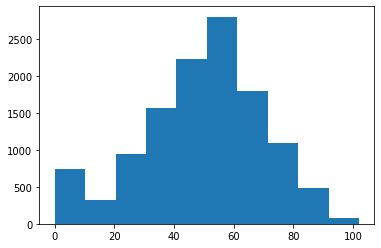

In [184]:
plt.hist(df2mx['age']);

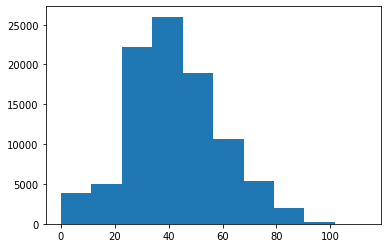

In [185]:
plt.hist(df3mx['age']);

pretty different distributions (shape) of age

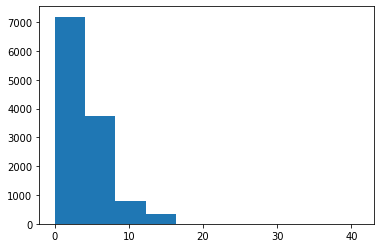

In [186]:
plt.hist(pd.to_numeric(df2mx['sympt2care']));

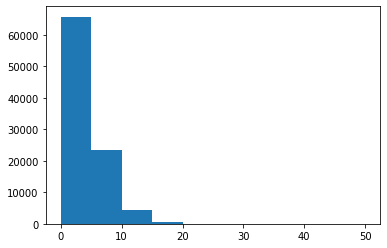

In [187]:
plt.hist(pd.to_numeric(df3mx['sympt2care']));

fairly similar for s2c

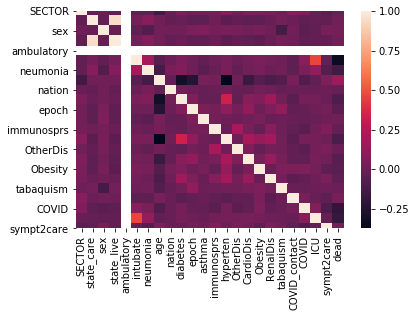

In [197]:
corr = df2mx.iloc[:,1:].corr()
corr_dead = pd.DataFrame(corr['dead'])
sns.heatmap(corr);

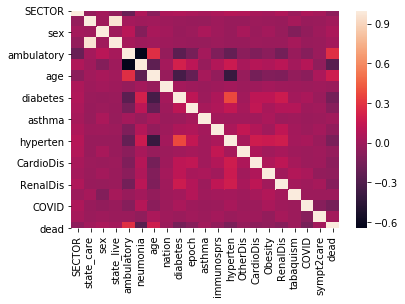

In [198]:
corr = df3mx.iloc[:,1:].corr()
corr_dead['dead2'] = corr['dead']
sns.heatmap(corr);

what variables are correlated with "dead"

In [199]:
corr_dead

,dead,dead2
SECTOR,0.000063,-0.058177
state_care,0.024451,0.016376
sex,0.037255,0.052854
state_live,0.025450,0.016783
ambulatory,NaN,0.282650
intubate,-0.328174,NaN
neumonia,-0.133801,-0.267888
age,0.158869,0.185122
nation,-0.005838,-0.011396
diabetes,-0.093887,-0.152680


Potential Predictors:

similar: age, hyperten
different: ambulatory, neumonia, COVID, 

## Modeling

## Logistic Regression

In [201]:
from sklearn.linear_model import LogisticRegression  # from wk6
from sklearn.metrics import mean_squared_error, r2_score

X = df2mx.iloc[:,:-1]
y = df2mx['dead']

lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr.fit(X, y)
#print(lr.coef_)
# print(lr.intercept_)
# print(y)
y_hat = lr.predict(X)
print(lr.score(X,y))
print(mean_squared_error(y,y_hat))

0.8884663083918974
0.11153369160810252


try smaller set of variables

In [202]:
X = df2mx[['age','intubate','neumonia','hyperten','ICU', 'COVID']]
y = df2mx['dead']

lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr.fit(X, y)
#print(lr.coef_)
# print(lr.intercept_)
# print(y)
y_hat = lr.predict(X)
print(lr.score(X,y))
print(mean_squared_error(y,y_hat))

0.8896238114923523
0.11037618850764778


nearly the same

In [203]:
#Wow, that's explains almost all of the variability in deaths (88%).
#What variables are influencial?

#log odds ratio
print(lr.coef_)

#odds ratio
print(np.exp(lr.coef_))

[[ 0.02387725 -1.75407472 -0.58976482 -0.26333576 -0.18420345 -0.93985666]]
[[1.02416459 0.1730673  0.55445767 0.76848383 0.83176657 0.39068383]]


Intubate, Neumonia and COVID diagnosis are influencial but negative? coding 1,2

In [204]:
X = df3mx.iloc[:,:-1]
y = df3mx['dead']

lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr.fit(X, y)
#print(lr.coef_)
# print(lr.intercept_)
# print(y)
y_hat = lr.predict(X)
print(lr.score(X,y))
print(mean_squared_error(y,y_hat))

0.9644518871024155
0.03554811289758455


In [206]:
X = df3mx[['age','ambulatory','diabetes','neumonia','hyperten', 'COVID']]
y = df3mx['dead']

lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr.fit(X, y)
#print(lr.coef_)
# print(lr.intercept_)
# print(y)
y_hat = lr.predict(X)
print(lr.score(X,y))
print(mean_squared_error(y,y_hat))

0.9643141037190914
0.03568589628090852


Nearly same and much better R2 than the smaller dataset(df2mx)

I would drop those 3 highly incomplete variables rather than drop 80% rows.

...but I didn't do train/test split.

In [207]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=301)

In [209]:
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr.fit(X_train, y_train)

y_hat = lr.predict(X_test)
print(lr.score(X_test,y_test))
print(mean_squared_error(y_test,y_hat))

0.9643178314491264
0.03568216855087359


very close to full data model

...but what about normalization?

In [211]:
from sklearn.preprocessing import normalize

X_copy = X.copy()
X_norm = normalize(X_copy)
y_model = LogisticRegression(solver='lbfgs', max_iter=1000).fit(X_norm, y).predict(X_norm)
mean_squared_error(y, y_model)

0.03554811289758455

Didn't make a differnece

age is the only variable on a dif scale

0.9643570267787748

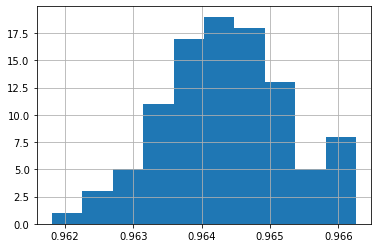

In [216]:
# Cross validation

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

reg = LogisticRegression(solver='lbfgs', max_iter=1000)
cv = ShuffleSplit(n_splits=100, test_size=0.3, random_state=301)

s = cross_val_score(reg, X, y, cv=cv)
pd.Series(s).hist()
s.mean() # R^2

In [ ]:
fairly robust to the choice of split

## K Nearest Neighbors

In [235]:
from sklearn.neighbors import KNeighborsClassifier

# KNN Classifier(K=1)
knnr = KNeighborsClassifier(n_neighbors=1)
knnr.fit(X_train, y_train)
y_hat = knnr.predict(X_test)
print(knnr.score(X_test,y_test))
print(mean_squared_error(y_test,y_hat))

0.9437949640287769
0.05620503597122302


In [233]:
from sklearn.neighbors import KNeighborsClassifier

# KNN Classifier(K=10)

y_hat = KNeighborsClassifier(n_neighbors=10).fit(X_train, y_train).predict(X_test)
mean_squared_error(y_test, y_hat)

0.03609969167523124

In [236]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter optimization:
# (Hyper)parameter grid
p_grid = {
    "n_neighbors": [1, 3, 5, 10, 15, 20, 50]
}

knnr = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=knnr, param_grid=p_grid, 
                           cv=ShuffleSplit(n_splits=10, test_size=0.3, random_state=301), 
                           iid=False)
grid_search.fit(X, y)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=301, test_size=0.3, train_size=None),
             error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid=False, n_jobs=None,
             param_grid={'n_neighbors': [1, 3, 5, 10, 15, 20, 50]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [237]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.253773,0.020863,2.493670,0.132889,1,{'n_neighbors': 1},0.945135,0.942274,0.938211,0.942168,0.940013,0.942274,0.944181,0.944888,0.941497,0.938988,0.941963,0.002252,7
1,0.264820,0.010324,2.720771,0.056794,3,{'n_neighbors': 3},0.957606,0.955098,0.954851,0.957076,0.953614,0.955946,0.955486,0.954780,0.955628,0.956087,0.955617,0.001096,6
2,0.241944,0.030683,2.747517,0.166992,5,{'n_neighbors': 5},0.960927,0.960821,0.960538,0.959161,0.957818,0.959373,0.959443,0.958701,0.958454,0.960609,0.959585,0.001035,5
3,0.252211,0.051825,2.978000,0.076476,10,{'n_neighbors': 10},0.963435,0.964813,0.963435,0.963859,0.962411,0.963930,0.963471,0.963930,0.964460,0.963435,0.963718,0.000622,3
4,0.260156,0.009250,3.033739,0.201912,15,{'n_neighbors': 15},0.962658,0.964636,0.963541,0.963435,0.962128,0.964001,0.963718,0.962976,0.964177,0.963259,0.963453,0.000704,4
5,0.257389,0.018726,3.287883,0.056837,20,{'n_neighbors': 20},0.964319,0.965237,0.964107,0.964142,0.963011,0.964425,0.964213,0.963895,0.964672,0.963683,0.964170,0.000560,2
6,0.241985,0.036922,3.568421,0.410165,50,{'n_neighbors': 50},0.964530,0.965555,0.964319,0.964636,0.963400,0.964530,0.964001,0.964001,0.965202,0.964177,0.964435,0.000586,1


In [238]:
grid_search.best_params_

{'n_neighbors': 50}

In [242]:
# KNN Classifier(K=20) chose 20 bec R^2 is nearly identical
knnr = KNeighborsClassifier(n_neighbors=50)
knnr.fit(X_train, y_train)
y_hat = knnr.predict(X_test)
print(knnr.score(X_test,y_test))
print(mean_squared_error(y_test,y_hat))

0.9645747687564235
0.03542523124357657


nearly same as logistic regression

## Deep Learning

In [249]:
#https://scikit-learn.org/stable/modules/neural_networks_supervised.html#

from sklearn.neural_network import MLPClassifier

mlpc = MLPClassifier(solver='lbfgs', alpha=1e-10,
                        hidden_layer_sizes=(15, 2), random_state=301)
mlpc.fit(X_train, y_train)
y_hat = mlpc.predict(X_test)
print(mlpc.score(X_test,y_test))
print(mean_squared_error(y_test,y_hat))

0.9645747687564235
0.03542523124357657


## Ensamble Learning

In [256]:
#https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(max_depth=None, 
                             min_samples_split=2,
                             random_state=301)
scores = cross_val_score(dtc, X, y, cv=5)
print(scores.mean())

rfc = RandomForestClassifier(n_estimators=10,
                             max_depth=None,
                             min_samples_split=2,
                             random_state=0)
scores = cross_val_score(rfc, X, y, cv=5)
print(scores.mean())


etc = ExtraTreesClassifier(n_estimators=10, 
                           max_depth=None,
                           min_samples_split=2,
                           random_state=0)
scores = cross_val_score(etc, X, y, cv=5)
print(scores.mean())

0.9623533219729064
0.9616432028945472
0.9623957167477727


In [257]:
#what if...we used the smaller dataset

X = df2mx.iloc[:,:-1]
y = df2mx['dead']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=301)

dtc = DecisionTreeClassifier(max_depth=None, 
                             min_samples_split=2,
                             random_state=301)
scores = cross_val_score(dtc, X, y, cv=5)
print(scores.mean())

rfc = RandomForestClassifier(n_estimators=10,
                             max_depth=None,
                             min_samples_split=2,
                             random_state=0)
scores = cross_val_score(rfc, X, y, cv=5)
print(scores.mean())


etc = ExtraTreesClassifier(n_estimators=10, 
                           max_depth=None,
                           min_samples_split=2,
                           random_state=0)
scores = cross_val_score(etc, X, y, cv=5)
print(scores.mean())

0.3971889210417528
0.6819346837536172
0.8613476643241007


## DOH!